# CPI Forecasting Project

This project focuses on analyzing and forecasting the Consumer Price Index (CPI) using historical data. The CPI is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care.

## Project Workflow

1. **Data Loading and Preprocessing**:
    - The CPI dataset is loaded and cleaned by removing missing values and converting the `date` column to a datetime format.
    - The data is resampled to a monthly frequency to simplify the analysis.

2. **Exploratory Data Analysis (EDA)**:
    - The monthly CPI data is visualized using line plots to observe trends and patterns over time.

3. **Train-Test Split**:
    - The dataset is split into training and testing sets based on a specific date (`2013-09-01`).
    - The training set is used to build the model, while the testing set is reserved for evaluation.

4. **Linear Regression Model**:
    - A linear regression model is trained on the training data to predict CPI values.
    - The model's coefficients and intercept are analyzed to understand the relationship between time and CPI.

5. **Residual Analysis**:
    - Residuals (differences between actual and predicted values) are calculated and visualized to assess the model's performance.
    - The autocorrelation and partial autocorrelation of residuals are analyzed to identify patterns.

6. **Time Series Modeling**:
    - An AutoRegressive (AR) model is fitted to the residuals to capture any remaining patterns not explained by the linear regression model.

7. **Evaluation and Visualization**:
    - The fitted values from the AR model are compared with the residuals to evaluate the model's performance.
    - The train and test sets, along with predictions, are visualized to assess the overall forecasting accuracy.




## Project Objectives

- Describe historical behavior of monthly CPI and identify trend components.
- Build a simple and interpretable forecasting pipeline: Linear Regression (trend) + AR on residuals (short-run dynamics).
- Evaluate forecasting performance on a hold-out test set using RMSE and diagnostic plots.
- Provide actionable conclusions and recommended next steps.

### Success criteria
- Readable notebook with clear sections and plots.
- A reproducible pipeline that produces an RMSE value and diagnostic plots.


## Importing and Preprocessing the data

## Data Overview

- Source: local CSV file `cpi.csv` (expected columns: `date`, `CPI`).
- Time span: monthly observations (resampled to month-start in the notebook).
- Preprocessing performed:
  - Convert `date` to datetime.
  - Resample to monthly frequency (MS) and reset index.
  - Train-test split at `2013-09-01`.

Notes: Ensure `cpi.csv` is in the same directory as this notebook before running; inspect the first few rows if needed (`cpi.head()`).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

## How to run this notebook

1. Place `cpi.csv` in the same folder as this notebook.
2. Restart the kernel and run all cells from top to bottom.
3. Recommended packages: pandas, numpy, matplotlib, seaborn, scikit-learn, statsmodels.

If a package is missing, install it via pip, for example:

```
# In a terminal
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels
```


In [4]:
cpi = pd.read_csv('cpi.csv')

cpi['date'] = pd.to_datetime(cpi['date'])
#cpi.dropna(inplace=True)
cpi.head()


,date,CPI
0,2008-07-24,100.0
1,2008-07-25,100.0
2,2008-07-26,100.0
3,2008-07-27,100.0
4,2008-07-28,100.0


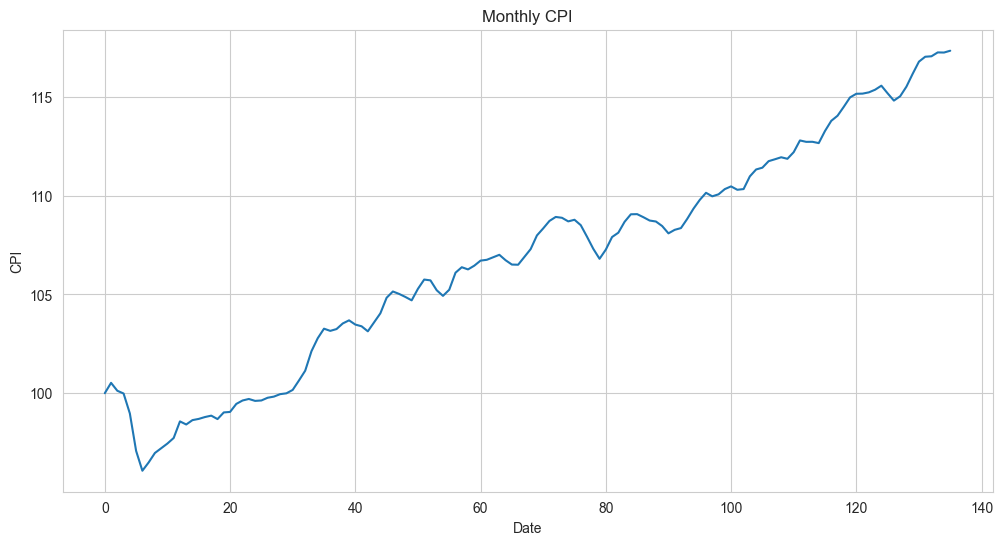

In [5]:
# Resample to monthly frequency, taking the first value of each month
monthly_cpi = cpi.copy()
monthly_cpi.set_index('date', inplace=True)  # Set 'date' as the index
monthly_cpi = monthly_cpi.resample('MS').first().reset_index()  # Resample and reset index
# Plot the monthly CPI
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_cpi.index, y=monthly_cpi['CPI'])  # Ensure column name is 'CPI'
plt.title('Monthly CPI')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.grid(True)



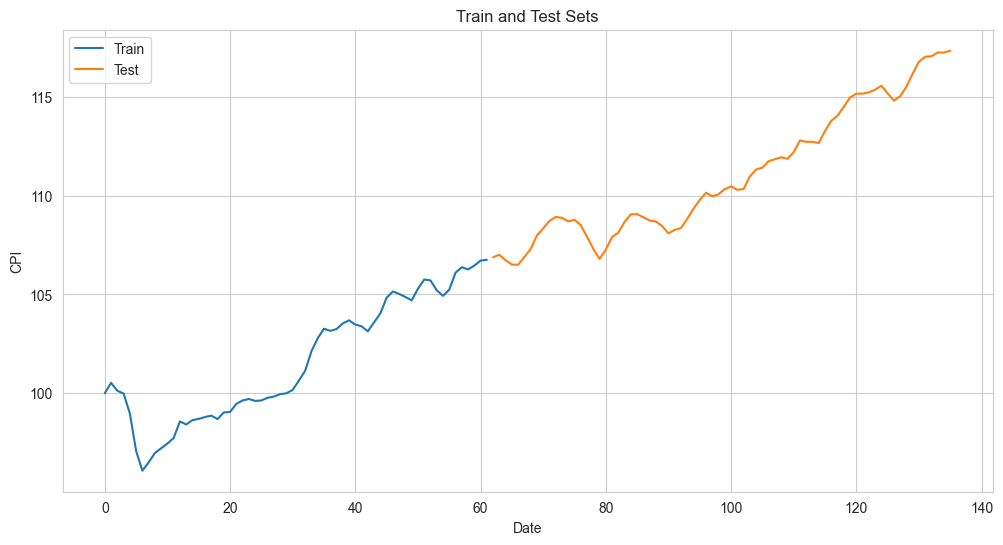

In [6]:
# split the data into train and test sets

train = monthly_cpi[monthly_cpi['date'] < '2013-09-01']
test = monthly_cpi[monthly_cpi['date'] >= '2013-09-01']

# Plot the train and test sets
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x=train.index, y='CPI', label='Train')
sns.lineplot(data=test, x=test.index, y='CPI', label='Test')
plt.title('Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)

Coefficients: [0.16104348]
Intercept: [96.72932633]


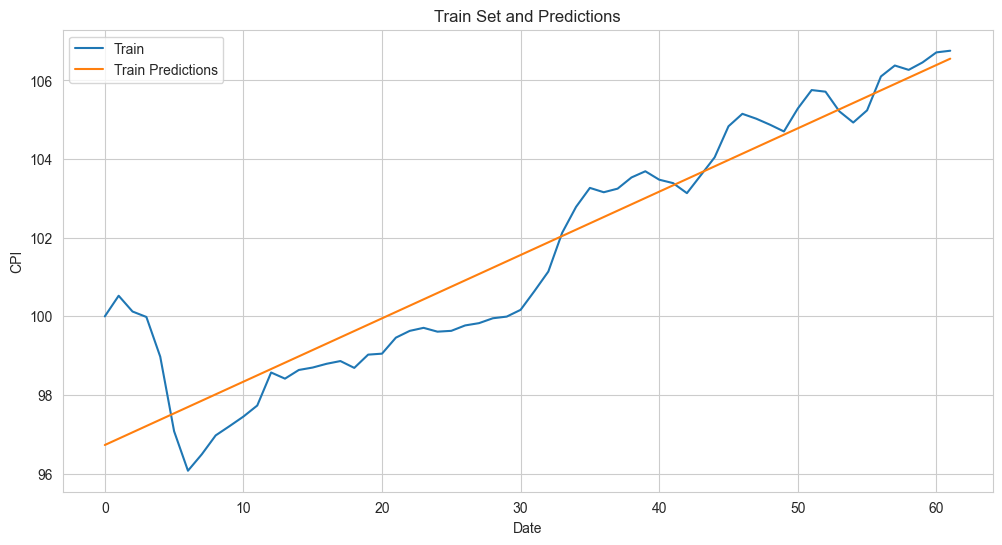

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X_train = np.array(train.index).reshape(-1, 1)
X_test = np.array(test.index).reshape(-1, 1)
y_train = np.array(train['CPI'].values.reshape(-1, 1))
model.fit(X_train, y_train)
# Predict on the train set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Coefficients:", model.coef_[0])
print("Intercept:", model.intercept_)
# plot the train set and predictions
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x=train.index, y='CPI', label='Train')
sns.lineplot(data=train, x=train.index, y=y_train_pred.flatten(), label='Train Predictions')
plt.title('Train Set and Predictions')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)



3.634730187605456


Text(0.5, 0, 'Predicted Values')

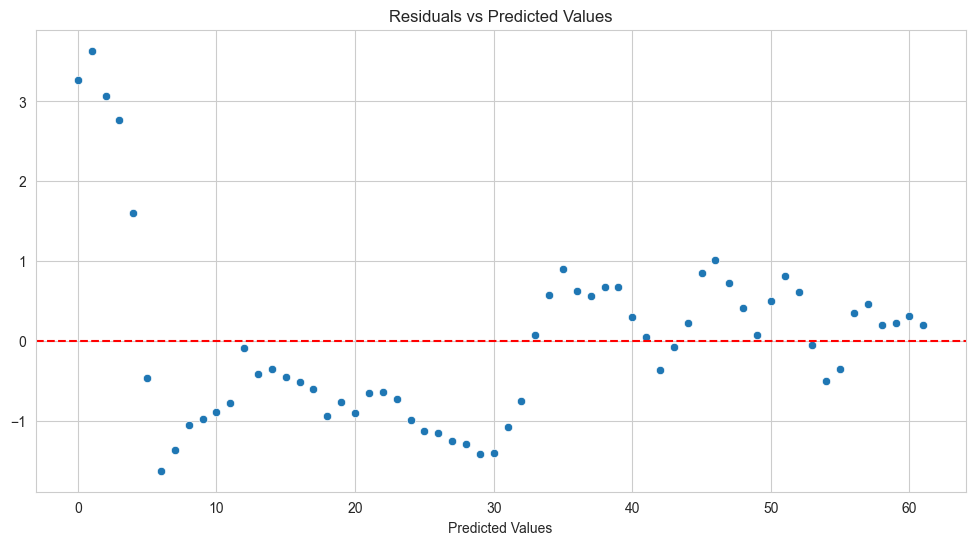

In [8]:
residuals = y_train - y_train_pred
print(residuals.max())
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train.index.to_numpy(), y=residuals.flatten())
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')

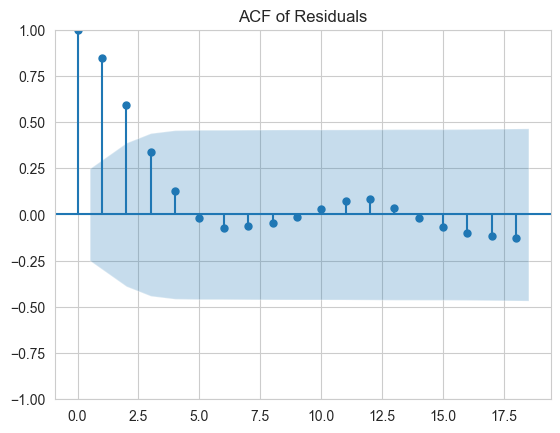

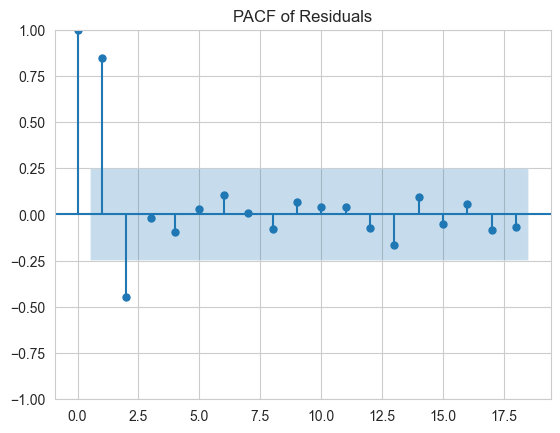

In [9]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()
sm.graphics.tsa.plot_pacf(residuals)
plt.title('PACF of Residuals')
plt.show()

In [10]:
# Fit a AR(2) model
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(residuals, lags=2).fit()
print(model.summary())

# Predict on the train & test sets
train_pred = model.predict(start=0, end=len(train)-1)
test_pred = model.forecast(steps=len(test))

# final model = Ar + linear regression

ar_train = train_pred + y_train_pred.flatten()
final_test = test_pred + y_test_pred.flatten()



                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 -17.470
Method:               Conditional MLE   S.D. of innovations              0.324
Date:                Tue, 15 Apr 2025   AIC                             42.939
Time:                        17:15:29   BIC                             51.317
Sample:                             2   HQIC                            46.216
                                   62                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0431      0.042     -1.024      0.306      -0.126       0.039
y.L1           1.3237      0.098     13.461      0.000       1.131       1.516
y.L2          -0.5308      0.091     -5.824      0.0

In [11]:
n = 2
AR2_model = AutoReg(residuals, lags= n).fit()# Here we have used the default value for the trend parameter
coef = AR2_model.params
print(coef)
remaining_test = test['CPI'].values - y_test_pred.flatten()
# walk forward over time steps in test
past = residuals[len(residuals)-n:]
past = [past[i] for i in range(len(past))]
test_predictions = []
training_predictions = AR2_model.predict(start = 0, end =len(train)-1)
for t in range(len(remaining_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n,length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = remaining_test[t]
    test_predictions.append(float(pred))  # Ensure pred is a scalar value
    past.append(obs)

final_train = training_predictions + y_train_pred.flatten()
final_test = test_predictions + y_test_pred.flatten()


[-0.04310485  1.32366553 -0.5307974 ]


C:\Users\LEGION\AppData\Local\Temp\ipykernel_21816\4133838416.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_predictions.append(float(pred))  # Ensure pred is a scalar value


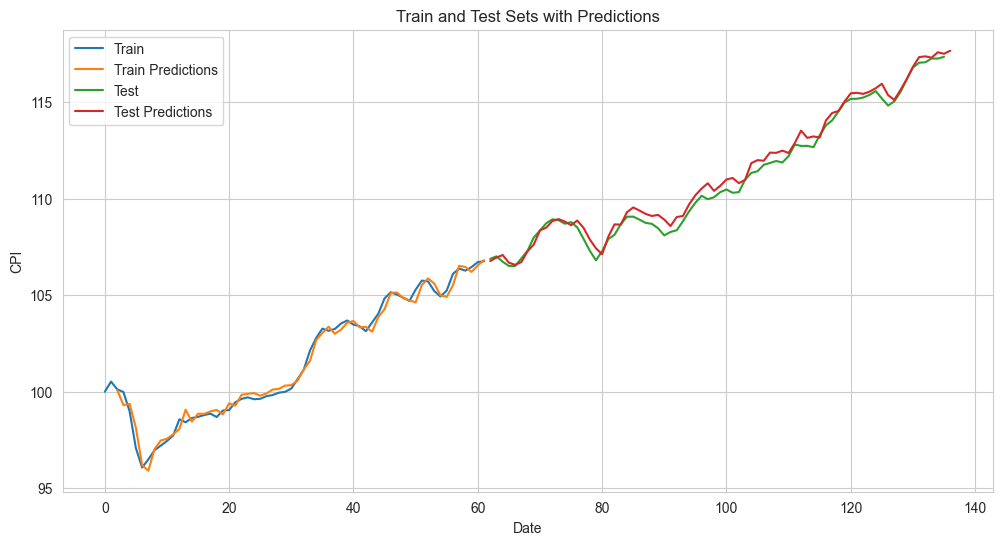

In [12]:
# plot the train set and predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x = train.index, y = train['CPI'], label='Train')
sns.lineplot(x = train.index, y = final_train, label='Train Predictions')
sns.lineplot(x = test.index, y = test['CPI'], label='Test')
sns.lineplot(x = test.index, y = final_test, label='Test Predictions')
plt.title('Train and Test Sets with Predictions')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()


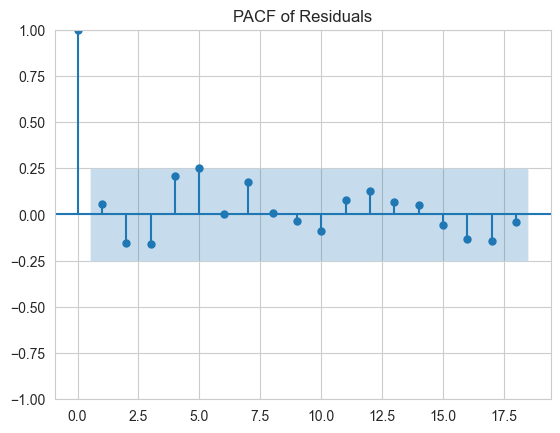

In [13]:
final_residuals = (residuals.flatten() - training_predictions)[2:]
sm.graphics.tsa.plot_pacf(final_residuals)
plt.title('PACF of Residuals')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test.dropna().CPI,final_test[:-1]))
print("The rmse of the final fit is " + str(rmse))

The rmse of the final fit is 0.39104043069964795


## Conclusions & Next Steps

- Summary: The combined model (Linear trend + AR on residuals) provides a simple, interpretable forecasting approach. The notebook reports RMSE on the test set and includes diagnostic plots (ACF/PACF) for residual analysis.

- Limitations:
  - The trend is modelled linearly; real-world CPI may have nonlinear trends and structural breaks.
  - AR on residuals captures short-term autocorrelation but may miss seasonality and exogenous drivers.

- Recommended next steps:
  1. Explore SARIMA or ETS models to capture seasonality.
  2. Add exogenous variables (energy prices, unemployment) for improved forecasts.
  3. Automate retraining and backtesting for rolling-window evaluation.
  4. Package results and plots into an exportable report (PDF or HTML).

---

End of notebook. Thank you.